In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/MyDrive/NEXCO/src/run_test/

Mounted at /content/drive
/content/drive/MyDrive/NEXCO/src/run_test


In [ ]:
!pip install japanize_matplotlib jpholiday
# !python run.py  --exec-path ./sample_submit/src/ --data-dir ./train/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=9ce6f34143abbf7a694cf356b1794a74ba465f1cd0439a16f10e90ed3f83f146
  Stored in directory: /root/.cache/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize_matplotlib


In [ ]:
# ========================================
# Library
# ========================================
import os
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
import argparse

import numpy as np
import pandas as pd
import datetime
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold
)# StratifiedGroupKFold, 
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

pd.set_option('display.max_columns', None)

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
set_seed()

class TestHoliday(jpholiday.OriginalHoliday):
    def _is_holiday(self, date):
        extra_holidays = [
            #GW
            datetime.date(2021, 4, 29), datetime.date(2022, 4, 29), datetime.date(2023, 4, 29),
            datetime.date(2021, 4, 30), datetime.date(2022, 4, 30), datetime.date(2023, 4, 30),
            datetime.date(2021, 5, 1), datetime.date(2022, 5, 1), datetime.date(2023, 5, 1),
            datetime.date(2021, 5, 2), datetime.date(2022, 5, 2), datetime.date(2023, 5, 2),
            datetime.date(2021, 5, 3), datetime.date(2022, 5, 3), datetime.date(2023, 5, 3),
            datetime.date(2021, 5, 4), datetime.date(2022, 5, 4), datetime.date(2023, 5, 4),
            datetime.date(2021, 5, 5), datetime.date(2022, 5, 5), datetime.date(2023, 5, 5),

            # お盆
            datetime.date(2021, 8, 13), datetime.date(2022, 8, 13), datetime.date(2023, 8, 13),
            datetime.date(2021, 8, 14), datetime.date(2022, 8, 14), datetime.date(2023, 8, 14),
            datetime.date(2021, 8, 15), datetime.date(2022, 8, 15), datetime.date(2023, 8, 15),

            #年末年始
            datetime.date(2021, 12, 31), datetime.date(2022, 12, 31), datetime.date(2023, 12, 31),
            datetime.date(2021, 1, 1), datetime.date(2022, 1, 1), datetime.date(2023, 1, 1),
            datetime.date(2021, 1, 2), datetime.date(2022, 1, 2), datetime.date(2023, 1, 2),
            datetime.date(2021, 1, 3), datetime.date(2022, 1, 3), datetime.date(2023, 1, 3),
        ]
        if date in extra_holidays:
            return True
        return False

# この中を変える
class ScoringService(object):

    @classmethod
    def get_model(cls, model_path, inference_df, TRAIN_MODE=False):
        """Get model method

        Args:
            model_path (str): Path to the trained model directory.
            inference_df: Past data not subject to prediction.

        Returns:
            bool: The return value. True for success.
        """
        cls.data = inference_df

        cls.cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'dayofweek', 'is_holiday', 'is_holiday_td', 'start_pref_code', 'end_pref_code', 'season']
        cls.num_cols = ['year', 'month', 'day', 'year_td', 'month_td', 'day_td', 'hour', 'search_1h', 'search_unspec_1d', 'KP', 'start_KP', 'end_KP', 'limit_speed', \
                    'straight_dist', 'KP_se_dist', 'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate', 'start_degree', 'end_degree', 'degree_diss_es', 'OCC', 'allCars', \
                    'sum_search_1h', 'mean_search_1h', 'med_search_1h', 'rate_search_1h']
        cls.feature_cols = cls.cat_cols + cls.num_cols

        cls.TRAIN_MODE = TRAIN_MODE

        cls.N_SPLIT = 5
        if not TRAIN_MODE:
            with open('../src/features/le_dict.pkl', 'rb') as f:
                cls.le = pickle.load(f)
            print(cls.le)
            cls.le_keys = list(cls.le.keys())
            # modelのロード
            cls.models = {}
            for n in range(cls.N_SPLIT):
                cls.models[n] = pickle.load(open(f'{model_path}/lgb_fold{n}.pickle', 'rb'))
        else:
            cls.models = None

        cls.params = {
            'objective': 'binary',
            'verbose': -1,
            'metric': 'binary_logloss',
            'seed': 0,

            'num_leaves': 52, 
            'learning_rate': 0.01, 
            'max_depth': 9,
            'min_data_in_leaf': 10, 
            'feature_fraction': 0.9351779629995216, 
            'bagging_fraction': 0.6384393631575852, 
            'lambda_l1': 0.9764594650133958, 
            'lambda_l2': 0.4686512016477016
        }

        # 一応過去のレコードを貯めることはできる
        return True

    @classmethod
    def predict(cls, input):
        """Predict method

        Args:
            input: meta data of the sample you want to make inference from (DataFrame)

        Returns:
            prediction: Inference for the given input. Return columns must be ['datetime', 'start_code', 'end_code'](DataFrame).
        
        Tips:
            You can use past data by writing "cls.data".
        """
        
        prediction = input.copy()

        # ======================== ここから特徴量作成 ========================

        prediction = cls.extract_dataset(prediction)

        # ======================== ここから予測 =============================

        prediction['prediction'] = 0
        for n in range(cls.N_SPLIT):
            prediction['prediction'] += cls.models[n].predict(prediction[cls.feature_cols]) / cls.N_SPLIT
        prediction['prediction'] = prediction['prediction'].round()
        prediction['prediction'] = prediction['prediction'].astype(int)
        prediction['start_code'] = input["start_code"]
        prediction['end_code'] = input["end_code"]
        prediction['datetime'] = input["datetime"]
        prediction = prediction[['datetime', 'start_code', 'end_code', 'prediction']]

        return prediction

    @classmethod
    def expand_datetime(cls, df):
        if 'datetime' in df.columns:
            df['year'] = df['datetime'].dt.year
            df['month'] = df['datetime'].dt.month
            df['day'] = df['datetime'].dt.day
            df['hour'] = df['datetime'].dt.hour
        if 'td' in df.columns:
            df['year_td'] = df['td'].dt.year
            df['month_td'] = df['td'].dt.month
            df['day_td'] = df['td'].dt.day
            df['hour_td'] = df['td'].dt.hour
        if 'date' in df.columns:
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day'] = df['date'].dt.day
        return df

    @classmethod
    def extract_dataset(cls, df):
        '''
        input: df
            df = valid[valid['datetime'].dt.date==d]
            1日分のデータフレーム(1d*24h*79section)
            予測日前日のtraffic + 予測日のsearch + road >> 予測

        output: ~~
        '''

        def is_jpholiday(date):
            if jpholiday.is_holiday(date) or 5<=date.weekday():
                return True
            else:
                return False

        # ========================================
        # 時間関連
        # 予測当日の日付
        # ========================================
        df['td'] = df['datetime'] + pd.to_timedelta(1, 'd')

        df['dayofweek'] = df['datetime'].dt.weekday
        df['dayofweek_td'] = df['td'].dt.weekday

        date = df.iloc[0]['datetime'].date()
        df['is_holiday'] = int(is_jpholiday(date))
        date = df.iloc[0]['datetime'].date()
        df['is_holiday_td'] = int(is_jpholiday(date))

        df = cls.expand_datetime(df)
        df['season'] = df['month_td'].apply(lambda x: (x % 12 + 3) // 3)

        # ========================================
        # 道路関連
        # ========================================
        df['section'] = df['start_code'].astype(str)+'_'+df['end_code'].astype(str)
        df['straight_dist'] = np.sqrt( (df['end_lat']-df['start_lat'])**2 + (df['end_lng']-df['start_lng'])**2 ) * 100
        df['KP_se_dist'] = np.abs(df['end_KP']-df['start_KP'])
        df['KP_te_dist'] = np.abs(df['end_KP']-df['KP'])
        df['KP_st_dist'] = np.abs(df['KP']-df['start_KP'])
        df['KP_max_dist'] = np.max(df[['KP_te_dist', 'KP_st_dist']], axis=1) / df['KP_se_dist']
        df['detour_rate'] = df['KP_se_dist']/df['straight_dist']
        df['degree_diss_es'] = df['end_degree'] - df['start_degree']

        # ========================================
        # ルート検索 関連
        # ========================================
        group_search = df.groupby('section').agg(
            mean_search_1h = ("search_1h", 'mean'),
            sum_search_1h = ("search_1h", 'sum'),
            med_search_1h = ("search_1h", 'median')
            ).reset_index()
        df = pd.merge(df.reset_index(), group_search, on='section', suffixes=('', '_grouped'), how='left').set_index('index')
        df['rate_search_1h'] = df['search_1h'] / df['sum_search_1h']
        df['rate_search_1h'] = df['rate_search_1h'].replace([np.inf, -np.inf, np.nan], -1)

        # ========================================
        # カテゴリ変数の処理
        # ========================================
        if not cls.TRAIN_MODE:
            for c in cls.le_keys:
                df[c] = cls.le[c].transform(df[c])

        return df

In [ ]:
"""
search_sec
    "過去7日間の中で", この時間にsection内を通る検索をした数
    >> この日の合計
search_unsec
    "昨日", このsectionを通る検索をした数


# search_secの合計, その日のall 検索hit section数
# search_sec 移動平均
# search_sec それより前or後の検索数 + 上り下り反対車線の
    行だけ or 帰り だけの検索
# *** 周りのsectionとの関連
# 正しく休日を捉える
    連休の中何日めなのか
# {館山, 関越} * {上り, 下り} → 4

# validationの回し方的にlag変数に限界がある
# 2つの車線でmodel分ける??
    館山道: 渋滞少ない 0.13%
    関越道: 渋滞多い 0.53%
# サグ部 下り坂から上り坂


原因: 減速の連鎖
サグや長い上り坂(高坂SAや東松山IC、嵐山PA、前橋IC)
勾配とスピードの変化にドライバーが気付きにくく
スピードが落ちると車間が詰まる
後続車はブレーキを踏んで速度を落とします

"""

'\nsearch_sec\n    "過去7日間の中で", この時間にsection内を通る検索をした数\n    >> この日の合計\nsearch_unsec\n    "昨日", このsectionを通る検索をした数\n\n# search_secの合計, その日のall 検索hit section数\n# search_sec 移動平均\n# search_sec それより前or後の検索数 + 上り下り反対車線の\n    行だけ or 帰り だけの検索\n# *** 周りのsectionとの関連\n# 正しく休日を捉える\n    連休の中何日めなのか\n# {館山, 関越} * {上り, 下り} → 4\n\n# validationの回し方的にlag変数に限界がある\n# 2つの車線でmodel分ける??\n    館山道: 渋滞少ない 0.13%\n    関越道: 渋滞多い 0.53%\n# サグ部 下り坂から上り坂\n\n\n原因: 減速の連鎖\nサグや長い上り坂(高坂SAや東松山IC、嵐山PA、前橋IC)\n勾配とスピードの変化にドライバーが気付きにくく\nスピードが落ちると車間が詰まる\n後続車はブレーキを踏んで速度を落とします\n\n'

In [ ]:

# 不変
def make_dataset(traffic, ic_master, search_spec, search_unspec):
    # 欠損値の除外
    traffic = traffic[traffic['speed'].isnull()==False]
    ic_master.dropna(inplace=True)
    search_spec.dropna(inplace=True)
    search_unspec.dropna(inplace=True)
    
    # datetimeからdateを作成
    traffic['date'] = traffic['datetime'].apply(lambda x: x.split()[0])

    # データのマージ
    traffic = traffic.merge(ic_master, on=['start_code', 'end_code'], how='left')
    traffic = traffic.merge(search_spec, on=['datetime', 'start_code', 'end_code'], how='left')
    traffic = traffic.merge(search_unspec, on=['date', 'start_code', 'end_code'], how='left')
    traffic.sort_values(['date', 'start_code', 'end_code'], inplace=True)
    traffic.reset_index(drop=True, inplace=True)
    traffic.drop(columns='date', inplace=True)

    # データ型の変更
    traffic['datetime'] = pd.to_datetime(traffic['datetime'])

    return traffic


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--exec-path', help = '/path/to/submit/src')
    parser.add_argument('--data-dir', help = '/path/to/train')
    parser.add_argument('--start-date', default = '2021-04-08', type = str, help='start date')
    parser.add_argument('--end-date', default = '2022-07-31', type = str, help='end date')
    args = parser.parse_args()

    return args

def train():

    # ========================================
    # training module
    # ========================================
    def f1(y_true, y_pred):
        y_pred = (y_pred > 0.5).astype(int)
        score = f1_score(y_true, y_pred)
        return 'f1', score, True

    def lgb_f1_score(y_hat, data):
        y_true = data.get_label()
        y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
        return 'f1', f1_score(y_true, y_hat), True

    def train_lgbm(X,
                y,
                cv,
                model_path = [],
                params: dict=None,
                verbose: int=100,
                weight_dict: dict=None,
                cat_cols: list=[]
                ):

        # パラメータがないときは、空の dict で置き換える
        if params is None:
            params = {}

        models = []

        n_records = len(X)
        # training data の target と同じだけのゼロ配列を用意
        oof_pred = np.zeros((n_records, ), dtype=np.float32)
        
        for i, (idx_train, idx_valid) in enumerate(cv):
            x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
            x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

            print(f'train shape = {x_train.shape}')
            print(f'valid shape = {x_valid.shape}')
            
            if weight_dict is None:
                print('Don\'t use sample weight.')
                lgb_train = lgb.Dataset(x_train, y_train)
            elif weight_dict[0] == 'balance':
                print('Using sample weight. {Balance}')
                lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
            else:
                print('Using sample weight.')
                print(weight_dict)
                lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight=weight_dict, y=y_train).astype('float32'))
                
            lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
            
            clf = lgb.train(params, lgb_train, 
                            valid_sets=[lgb_train, lgb_eval],
                            valid_names=['Train', 'Valid'],
                            feval=lgb_f1_score,
                            num_boost_round=100000,
                            verbose_eval=20,
                            categorical_feature=cat_cols,
                            callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]
                            )# categorical_feature=categories, verbose_eval=10
            
            pred_i = clf.predict(x_valid)
            oof_pred[idx_valid] = pred_i
            models.append(clf)
            score = f1_score(y_valid, (pred_i > 0.5).astype(int))
            print(f" - fold{i + 1} - {score:.4f} \n")
            
        score = f1_score(y, (oof_pred > 0.5).astype(int))

        print("=" * 50)
        print(f"FINISH: CV Score: {score:.4f}")
        return score, oof_pred, models

    # parse the arguments
    """
    args = parse_args()
    exec_path = os.path.abspath(args.exec_path)
    data_dir = os.path.abspath(args.data_dir)
    start_date = args.start_date
    end_date = args.end_date

    !python run.py  --exec-path ./sample_submit/src/ --data-dir ./train/
    """
    exec_path = '/content/drive/MyDrive/NEXCO/src/run_test/sample_submit/src'
    data_dir = '/content/drive/MyDrive/NEXCO/src/run_test/train/'
    start_date = '2021-04-08'
    end_date = '2022-07-31'

    print('\nstart date: {}, end date:{}'.format(start_date, end_date))

    # load the input data
    print('\nLoading Dataset...')
    traffic = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    search_spec = pd.read_csv(os.path.join(data_dir, 'search_data.csv'))
    search_unspec = pd.read_csv(os.path.join(data_dir, 'search_unspec_data.csv'))
    ic_master = pd.read_csv(os.path.join(data_dir, 'road.csv'))

    # 当日の検索数を使用できるように変更(search_spec, search_unspec)
    search_spec['datetime'] = pd.to_datetime(search_spec['datetime'])
    search_unspec['date'] = pd.to_datetime(search_unspec['date'])
    search_spec['datetime'] -= pd.to_timedelta(1, 'd')
    search_unspec['date'] -= pd.to_timedelta(1, 'd')
    search_spec['datetime'] = search_spec['datetime'].astype('str')
    search_unspec['date'] = search_unspec['date'].astype('str')

    df = make_dataset(traffic, ic_master, search_spec, search_unspec)
    train = df[(df['datetime']>=start_date+' 00:00:00') & (df['datetime']<=end_date+' 23:00:00')]
    print('Done')

    # change the working directory
    model_path = './sample_submit/model/'
    ScoringService.get_model(model_path, None, TRAIN_MODE=True)

    # prepare training data
    train_all = pd.DataFrame()
    for d in tqdm(train['datetime'].dt.date.unique()):
        input = train[train['datetime'].dt.date==d]
        input = ScoringService.extract_dataset(input)
        train_all = pd.concat([train_all, input])

    le_dict = {}# only training
    for c in ScoringService.cat_cols:
        if train_all[c].dtype=='object':
            le = LabelEncoder()# only training
            print(c)
            print(train_all[c].value_counts())
            le.fit(train_all[c])# only training
            train_all[c] = le.transform(train_all[c])
            le_dict[c] = le# only training

    with open("./sample_submit/src/features/le_dict.pkl", "wb") as f:# only training
        pickle.dump(le_dict, f)# only training

    # training
    train_all.sort_values(['section', 'datetime'])
    train_all['is_congestion'] = train_all.groupby('section').shift(-24).reset_index()['is_congestion']
    train_all = train_all[~train_all['is_congestion'].isnull()].reset_index(drop=True)

    # ========================================
    # train-validation split
    # ========================================
    strat_TARGET = 'dayofweek'
    TARGET = 'is_congestion'
    N_SPLIT = ScoringService.N_SPLIT
    kf = StratifiedGroupKFold(N_SPLIT)
    cv_list = list(kf.split(train_all, y=train_all[strat_TARGET], groups=train_all['datetime'].dt.date))

    X = train_all[ScoringService.feature_cols]
    y = train_all[TARGET]
    print('train all shape:', X.shape)
    print('train columns: \n', X.columns)

    weight = {0:1.0, 1:5.0}
    score, oof_pred, models = train_lgbm(X, y=y, params=ScoringService.params, cv=cv_list, weight_dict=weight, cat_cols=ScoringService.cat_cols)# 0.5814 <> shuffle 5810

    for i, m in enumerate(models):
        with open(f'./sample_submit/model/lgb_fold{i}.pickle', mode="wb") as f:
            pickle.dump(m, f)

    # ========================================
    # feature importance
    # ========================================
    def visualize_importance(models, feat_train_df):
        feature_importance_df = pd.DataFrame()
        for i, model in enumerate(models):
            _df = pd.DataFrame()
            importance_type = 'split'
            _df["feature_importance"] = model.feature_importance(importance_type=importance_type)
            _df["column"] = feat_train_df.columns
            _df["fold"] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, _df],
                                            axis=0, ignore_index=True)

        order = feature_importance_df.groupby("column")\
            .sum()[["feature_importance"]]\
            .sort_values("feature_importance", ascending=False).index

        fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
        sns.boxplot(data=feature_importance_df,
                    x="feature_importance",
                    y="column",
                    order=order,
                    ax=ax,
                    palette="viridis",
                    orient="h")
        ax.tick_params(axis="x", rotation=90)
        ax.set_title("Importance")
        ax.grid()
        fig.tight_layout()
        return fig, ax, feature_importance_df

    fig, ax, feature_importance_df = visualize_importance(models, X)

def main():

    # parse the arguments
    """
    args = parse_args()
    exec_path = os.path.abspath(args.exec_path)
    data_dir = os.path.abspath(args.data_dir)
    start_date = args.start_date
    end_date = args.end_date

    !python run.py  --exec-path ./sample_submit/src/ --data-dir ./train/
    """
    exec_path = '/content/drive/MyDrive/NEXCO/src/run_test/sample_submit/src'
    data_dir = '/content/drive/MyDrive/NEXCO/src/run_test/train/'
    start_date = '2021-04-08'
    end_date = '2022-07-31'

    print('\nstart date: {}, end date:{}'.format(start_date, end_date))

    # load the input data
    print('\nLoading Dataset...')
    traffic = pd.read_csv(os.path.join(data_dir, 'train.csv'))
    search_spec = pd.read_csv(os.path.join(data_dir, 'search_data.csv'))
    search_unspec = pd.read_csv(os.path.join(data_dir, 'search_unspec_data.csv'))
    ic_master = pd.read_csv(os.path.join(data_dir, 'road.csv'))

    # 当日の検索数を使用できるように変更(search_spec, search_unspec)
    search_spec['datetime'] = pd.to_datetime(search_spec['datetime'])
    search_unspec['date'] = pd.to_datetime(search_unspec['date'])
    search_spec['datetime'] -= pd.to_timedelta(1, 'd')
    search_unspec['date'] -= pd.to_timedelta(1, 'd')
    search_spec['datetime'] = search_spec['datetime'].astype('str')
    search_unspec['date'] = search_unspec['date'].astype('str')

    df = make_dataset(traffic, ic_master, search_spec, search_unspec)
    train = df[df['datetime']<start_date+' 00:00:00']
    valid = df[(df['datetime']>=start_date+' 00:00:00') & (df['datetime']<=end_date+' 23:00:00')]
    print('Done')

    # change the working directory
    os.chdir(exec_path)
    cwd = os.getcwd()
    print('\nMoved to {}'.format(cwd))
    model_path = os.path.join('..', 'model')
    print('Model papth = {}'.format(model_path))
    sys.path.append(cwd)

    # load the model
    # from predictor import ScoringService

    print('\nLoading the model...', end = '\r')
    model_flag = ScoringService.get_model(model_path, train)
    if model_flag:
        print('Loaded the model.')
    else:
        print('Could not load the model.')
        return None

    predictions = pd.DataFrame()
    for d in tqdm(valid['datetime'].dt.date.unique()):
        input = valid[valid['datetime'].dt.date==d]
        prediction = ScoringService.predict(input)
        if type(prediction)!= pd.DataFrame:
            print('Invalid data type in the prediction. Must be pandas.DataFrame')
            return None 
        elif set(prediction.columns) != set(['datetime', 'start_code', 'end_code', 'prediction']):
            print('Invalid columns name: {},  Excepted name: {}'.format(prediction.columns, {'datetime', 'start_code', 'end_code', 'prediction'}))
            return None
        predictions = pd.concat([predictions, prediction])

    print(predictions)
    results = valid[['datetime', 'start_code', 'end_code']]
    results = pd.merge(results, predictions, on=['datetime', 'start_code', 'end_code'], how='left')
    results['datetime'] = pd.to_datetime(results['datetime'])
    results['datetime'] += pd.to_timedelta(1, 'd')
    results = pd.merge(results, df[['datetime', 'start_code', 'end_code', 'is_congestion']], on=['datetime', 'start_code', 'end_code'], how='inner')

    #compute F1SCORE
    print('\n==================')
    print('f1_score:', round(f1_score(results['is_congestion'], results['prediction']), 4))
    print('==================')



start date: 2021-04-08, end date:2022-07-31

Loading Dataset...
Done


100%|██████████| 480/480 [04:22<00:00,  1.83it/s]


section
1110210_1800006    11520
1800086_1800081    11520
1800106_1800111    11520
1800106_1800096    11520
1800096_1800106    11520
                   ...  
1800026_1800021    11520
1800021_1800026    11520
1800021_1800016    11520
1800016_1800021    11520
1800183_1800176    11520
Name: section, Length: 79, dtype: int64
direction
上り    460800
下り    449280
Name: direction, dtype: int64
train all shape: (908184, 39)
train columns: 
 Index(['road_code', 'start_code', 'end_code', 'section', 'direction',
       'dayofweek', 'is_holiday', 'is_holiday_td', 'start_pref_code',
       'end_pref_code', 'season', 'year', 'month', 'day', 'year_td',
       'month_td', 'day_td', 'hour', 'search_1h', 'search_unspec_1d', 'KP',
       'start_KP', 'end_KP', 'limit_speed', 'straight_dist', 'KP_se_dist',
       'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate',
       'start_degree', 'end_degree', 'degree_diss_es', 'OCC', 'allCars',
       'sum_search_1h', 'mean_search_1h', 'med_search_1h', 'rate_s

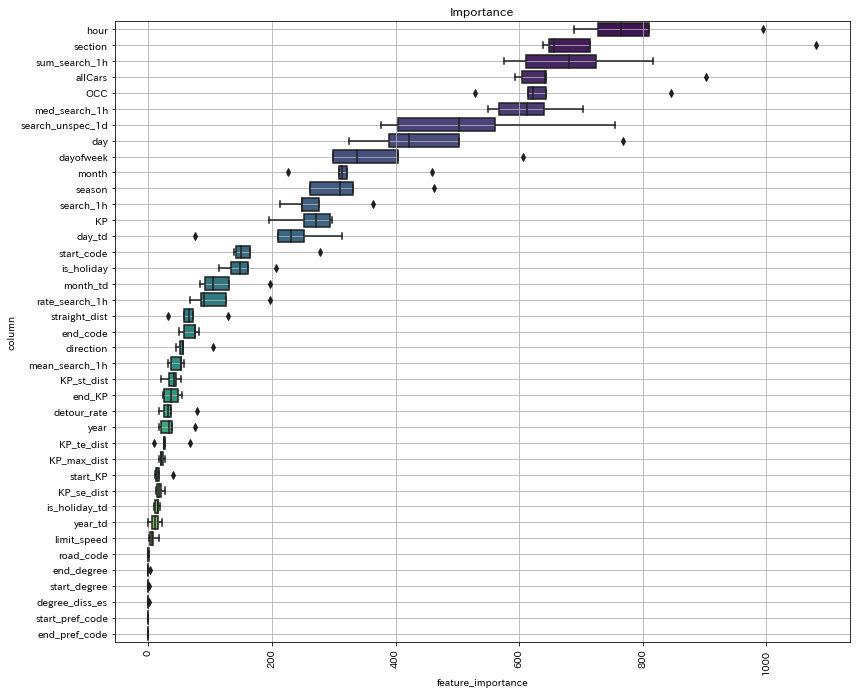

In [ ]:
train()

In [ ]:
# fold毎の違いが精度のきも???

In [ ]:
main()


start date: 2021-04-08, end date:2022-07-31

Loading Dataset...
Done

Moved to /content/drive/MyDrive/NEXCO/src/run_test/sample_submit/src
Model papth = ../model

{'section': LabelEncoder(), 'direction': LabelEncoder()}
Loaded the model.


100%|██████████| 480/480 [04:15<00:00,  1.88it/s]


                  datetime  start_code  end_code  prediction
index                                                       
0      2021-04-08 00:00:00     1110210   1800006           0
1      2021-04-08 01:00:00     1110210   1800006           0
2      2021-04-08 02:00:00     1110210   1800006           0
3      2021-04-08 03:00:00     1110210   1800006           0
4      2021-04-08 04:00:00     1110210   1800006           0
...                    ...         ...       ...         ...
910075 2022-07-31 19:00:00     1800183   1800176           0
910076 2022-07-31 20:00:00     1800183   1800176           0
910077 2022-07-31 21:00:00     1800183   1800176           0
910078 2022-07-31 22:00:00     1800183   1800176           0
910079 2022-07-31 23:00:00     1800183   1800176           0

[910080 rows x 4 columns]

f1_score: 0.6366


In [ ]:
"""
{'section': LabelEncoder(), 'direction': LabelEncoder()}
Loaded the model.
100%|██████████| 480/480 [03:36<00:00,  2.21it/s]
                datetime  start_code   end_code  prediction
0    2021-04-08 00:00:00   1110210.0  1800006.0           0
1    2021-04-08 01:00:00   1110210.0  1800006.0           0
2    2021-04-08 02:00:00   1110210.0  1800006.0           0
3    2021-04-08 03:00:00   1110210.0  1800006.0           0
4    2021-04-08 04:00:00   1110210.0  1800006.0           0
...                  ...         ...        ...         ...
1891                 NaT         NaN        NaN           0
1892                 NaT         NaN        NaN           0
1893                 NaT         NaN        NaN           0
1894                 NaT         NaN        NaN           0
1895                 NaT         NaN        NaN           0

[910080 rows x 4 columns]
"""

"\n{'section': LabelEncoder(), 'direction': LabelEncoder()}\nLoaded the model.\n100%|██████████| 480/480 [03:36<00:00,  2.21it/s]\n                datetime  start_code   end_code  prediction\n0    2021-04-08 00:00:00   1110210.0  1800006.0           0\n1    2021-04-08 01:00:00   1110210.0  1800006.0           0\n2    2021-04-08 02:00:00   1110210.0  1800006.0           0\n3    2021-04-08 03:00:00   1110210.0  1800006.0           0\n4    2021-04-08 04:00:00   1110210.0  1800006.0           0\n...                  ...         ...        ...         ...\n1891                 NaT         NaN        NaN           0\n1892                 NaT         NaN        NaN           0\n1893                 NaT         NaN        NaN           0\n1894                 NaT         NaN        NaN           0\n1895                 NaT         NaN        NaN           0\n\n[910080 rows x 4 columns]\n"

In [ ]:
"""
start date: 2021-04-08, end date:2022-07-31

Loading Dataset...
Done
100%|██████████| 480/480 [02:20<00:00,  3.42it/s]
train all shape: (908184, 35)
train columns: 
 Index(['road_code', 'start_code', 'end_code', 'section', 'direction',
       'dayofweek', 'is_holiday', 'is_holiday_td', 'start_pref_code',
       'end_pref_code', 'season', 'year', 'month', 'day', 'year_td',
       'month_td', 'day_td', 'hour', 'search_1h', 'search_unspec_1d', 'KP',
       'start_KP', 'end_KP', 'limit_speed', 'straight_dist', 'KP_se_dist',
       'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate',
       'start_degree', 'end_degree', 'degree_diss_es', 'OCC', 'allCars'],
      dtype='object')
train shape = (726168, 35)
valid shape = (182016, 35)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0433048	Train's f1: 0.52973	Valid's binary_logloss: 0.0209946	Valid's f1: 0.522523
[200]	Train's binary_logloss: 0.0326132	Train's f1: 0.638095	Valid's binary_logloss: 0.0170196	Valid's f1: 0.584356
[300]	Train's binary_logloss: 0.0276619	Train's f1: 0.655167	Valid's binary_logloss: 0.0156014	Valid's f1: 0.584703
Early stopping, best iteration is:
[227]	Train's binary_logloss: 0.0309826	Train's f1: 0.646968	Valid's binary_logloss: 0.0165003	Valid's f1: 0.590604
 - fold1 - 0.5906 

train shape = (726168, 35)
valid shape = (182016, 35)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0426736	Train's f1: 0.537978	Valid's binary_logloss: 0.0229667	Valid's f1: 0.5522
[200]	Train's binary_logloss: 0.0321598	Train's f1: 0.635226	Valid's binary_logloss: 0.0196726	Valid's f1: 0.554688
Early stopping, best iteration is:
[140]	Train's binary_logloss: 0.0373128	Train's f1: 0.616125	Valid's binary_logloss: 0.0212205	Valid's f1: 0.59816
 - fold2 - 0.5982 

train shape = (726168, 35)
valid shape = (182016, 35)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0428572	Train's f1: 0.541676	Valid's binary_logloss: 0.02164	Valid's f1: 0.506641
[200]	Train's binary_logloss: 0.0321758	Train's f1: 0.648584	Valid's binary_logloss: 0.0174012	Valid's f1: 0.54786
[300]	Train's binary_logloss: 0.0270436	Train's f1: 0.660412	Valid's binary_logloss: 0.0156895	Valid's f1: 0.547322
Early stopping, best iteration is:
[218]	Train's binary_logloss: 0.030979	Train's f1: 0.647127	Valid's binary_logloss: 0.0169808	Valid's f1: 0.554455
 - fold3 - 0.5545 

train shape = (726168, 35)
valid shape = (182016, 35)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0426093	Train's f1: 0.549933	Valid's binary_logloss: 0.0225878	Valid's f1: 0.446251
[200]	Train's binary_logloss: 0.032021	Train's f1: 0.644713	Valid's binary_logloss: 0.0190057	Valid's f1: 0.496251
Early stopping, best iteration is:
[162]	Train's binary_logloss: 0.0349298	Train's f1: 0.637367	Valid's binary_logloss: 0.0199217	Valid's f1: 0.503852
 - fold4 - 0.5039 

train shape = (728064, 35)
valid shape = (180120, 35)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0438301	Train's f1: 0.529202	Valid's binary_logloss: 0.0209725	Valid's f1: 0.506718
[200]	Train's binary_logloss: 0.0330797	Train's f1: 0.638687	Valid's binary_logloss: 0.0167894	Valid's f1: 0.584235
[300]	Train's binary_logloss: 0.0282798	Train's f1: 0.651866	Valid's binary_logloss: 0.0151186	Valid's f1: 0.574483
Early stopping, best iteration is:
[218]	Train's binary_logloss: 0.0319759	Train's f1: 0.639012	Valid's binary_logloss: 0.016379	Valid's f1: 0.586989
 - fold5 - 0.5870 

==================================================
FINISH: CV Score: 0.5670
"""

"\nstart date: 2021-04-08, end date:2022-07-31\n\nLoading Dataset...\nDone\n100%|██████████| 480/480 [02:20<00:00,  3.42it/s]\ntrain all shape: (908184, 35)\ntrain columns: \n Index(['road_code', 'start_code', 'end_code', 'section', 'direction',\n       'dayofweek', 'is_holiday', 'is_holiday_td', 'start_pref_code',\n       'end_pref_code', 'season', 'year', 'month', 'day', 'year_td',\n       'month_td', 'day_td', 'hour', 'search_1h', 'search_unspec_1d', 'KP',\n       'start_KP', 'end_KP', 'limit_speed', 'straight_dist', 'KP_se_dist',\n       'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate',\n       'start_degree', 'end_degree', 'degree_diss_es', 'OCC', 'allCars'],\n      dtype='object')\ntrain shape = (726168, 35)\nvalid shape = (182016, 35)\nUsing sample weight.\n{0: 1.0, 1: 5.0}\nTraining until validation scores don't improve for 100 rounds.\n[100]\tTrain's binary_logloss: 0.0433048\tTrain's f1: 0.52973\tValid's binary_logloss: 0.0209946\tValid's f1: 0.522523\n[200]\tTrain's 